In [4]:
# 최종 파일
import csv  # csv 파일 입출력
import os  # directory 관련
import shutil  # 파일 복사


In [5]:
# csv 속 1열의 file_name과 2열의 name(가수이름)을 리스트에 할당함
# input_csv 는 csv 파일, file_name와 singer_name은 리스트
def read_file(input_csv, file_name, singer_name):          
    with open(input_csv, 'r', newline='')as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)                                     # 1행 데이터 패스
        for row in csv_reader:
            if len(row) >= 1:
                file_name.append(row[0])                    
                singer_name.append(row[1])                 

In [6]:
# 이미지를 train과 test로 나눠서 복사하는 용도
# original_folder는 원본파일이 있는 폴더경로, target_folder는 복사파일을 담을 폴더경로 입력
def copy_data(original_folder, target_folder):                  
    for filename in os.listdir(original_folder):
        original_path = os.path.join(original_folder, filename)
        target_path = os.path.join(target_folder, filename)
        shutil.copy(original_path, target_path)


In [7]:
# 이미지 이름을 학습하기 좋게 바꿈
# file_name, singer_name은 리스트
def name_change(file_name, singer_name):
    for i in range(len(file_name)):
        renamed_image = singer_name[i]+"_"+file_name[i]
        os.rename(file_name[i], renamed_image)

In [8]:
# 폴더 내의 이미지 크기를 160*160로 변경함
import cv2
def resize_images(folder_path):
    # 폴더 내의 파일들을 가져옴
    file_list = os.listdir(folder_path)
    
    # 폴더 내의 각 파일에 대해 크기 조정
    for file_name in file_list:
        # 파일 확장자 확인
        if file_name.endswith(".jpg"):
            # 이미지 파일 경로 생성
            file_path = os.path.join(folder_path, file_name)
            
            # 이미지 로드
            image = cv2.imread(file_path)
            
            # 이미지 크기 조정
            resized_image = cv2.resize(image, (160, 160))
            
            # 크기 조정된 이미지 저장
            cv2.imwrite(file_path, resized_image)


In [9]:
work_space='c:/Users/user/Desktop/DLP_project/'

train_csv = work_space+"kpopfemale/kid_f_train.csv"     # train csv
test_csv = work_space+"kpopfemale/kid_f_test.csv"       # test csv 
traindata_folder = work_space+"kpopfemale/HQ_512x512/HQ_512x512"    # 이미지 데이터가 저장되어 있는 폴더

In [10]:
# train과 test 폴더 생성 및 각종 리스트 선언
os.mkdir(work_space+"train")
train_folder = work_space+"train"

os.mkdir(work_space+"test")
test_folder = work_space+"test"

train_file = []       # train 이미지 파일 이름 리스트
train_singer = []     # train 이미지 가수 이름 리스트
test_file = []        # test 이미지 파일 이름 리스트
test_singer = []      # test 이미지 가수 이름 리스트

In [11]:
# train csv 안에 레이블을 이미지에 할당하고, 데이터폴더 안에 이미지 파일의 이름을 "인물이름_파일이름.jpg"로 변경 후 사진 데이터 크기를 512*512 -> 160*160 변경
# test도 이하 동일
read_file(train_csv, train_file, train_singer)
copy_data(traindata_folder, train_folder)
resize_images(train_folder)
os.chdir(train_folder)
name_change(train_file, train_singer)


os.chdir(test_folder)

# test
read_file(test_csv, test_file, test_singer)
copy_data(traindata_folder, test_folder)
resize_images(test_folder)
os.chdir(test_folder)
name_change(test_file, test_singer)

In [12]:
# 클래스를 선언하기 위해 train_singer, test_singer 리스트의 요소들의 중복을 제거한다. 가수이름의 폴더를 생성하고 각각에 가수이미지를 옮긴다.
norepeated_singer=[]    
for i in train_singer:
    if i not in norepeated_singer:
        norepeated_singer.append(i)

for k in norepeated_singer:
    train_folder_path=os.path.join(work_space+"train",k)
    os.makedirs(train_folder_path, exist_ok=True)
    for imagename in os.listdir(work_space+"train"):
        if imagename.endswith('.jpg') and k in imagename:
              src_path = os.path.join(work_space+"train", imagename)
              dst_path = os.path.join(train_folder_path, imagename)
              shutil.move(src_path, dst_path)  # 파일을 해당 폴더로 이동

for m in norepeated_singer:
    test_folder_path=os.path.join(work_space+"test",m)
    os.makedirs(test_folder_path, exist_ok=True)
    for imagename in os.listdir(work_space+"test"):
        if imagename.endswith('.jpg') and m in imagename:
              src_path = os.path.join(work_space+"test", imagename)
              dst_path = os.path.join(test_folder_path, imagename)
              shutil.move(src_path, dst_path)  # 파일을 해당 폴더로 이동


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows=160  # 이미지 높이
cols=160  # 이미지 너비

In [14]:
# MobileNetV2 모델 생성
trained_model=MobileNetV2(input_shape=(rows,cols,3),           # 입력 이미지 형태: 높이 160 너비 160 컬러 이미지 색상: RGB
                    include_top=False,                          
                    weights='imagenet')                        # ImageNet 데이터셋의 사전 훈련된 가중치 사용
trained_model.trainable=True                                   # 훈련 가능하도록 설정
# trained_model.summary()

In [15]:
# 마지막 레이어를 드롭아웃으로 선언
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [16]:
# accuracy가 98%가 되면 콜백함수를 이용해 학습을 멈춤
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

In [17]:
# 마지막 레이어를 드롭아웃으로 정해서 추가한 후(과대 적합 방지) softmax를 이용한 Dense 레이어 추가
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)

x = tf.keras.layers.Dropout(0.8)(x)                               
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(55,activation='softmax')(x)           # 55는 클래스(인물) 수

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',                  # 모델 컴파일 손실함수
              optimizer=tf.keras.optimizers.Adam(1e-4),         # adam 옵티마이저(최적화)
              metrics=['accuracy'])                             # 평가지표

# model.summary()

In [18]:
train_datagen = ImageDataGenerator(rescale=1/255,                   
                                 shear_range=0.2,                   
                                 zoom_range=0.2,                    
                                 horizontal_flip=True,              
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
                                 
test_datagen = ImageDataGenerator(rescale=1/255)
train_dir=work_space+"train"
test_dir=work_space+"test"
train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(rows,cols),
                                                  class_mode='categorical')

test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(rows,cols),
                                                class_mode='categorical')

Found 5591 images belonging to 55 classes.
Found 235 images belonging to 55 classes.


In [19]:
# 모델 학습 시작
result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=50,
                 callbacks=[callbacks],
                 verbose=1)

Epoch 1/50
175/175 [==============================] - 44s 196ms/step - loss: 2.9696 - accuracy: 0.3180 - val_loss: 3.7324 - val_accuracy: 0.3191
Epoch 2/50
175/175 [==============================] - 32s 183ms/step - loss: 1.6901 - accuracy: 0.5679 - val_loss: 2.5761 - val_accuracy: 0.4553
Epoch 3/50
175/175 [==============================] - 33s 187ms/step - loss: 1.3810 - accuracy: 0.6437 - val_loss: 1.8203 - val_accuracy: 0.5234
Epoch 4/50
175/175 [==============================] - 32s 184ms/step - loss: 1.1745 - accuracy: 0.6963 - val_loss: 2.3316 - val_accuracy: 0.4255
Epoch 5/50
175/175 [==============================] - 32s 184ms/step - loss: 1.0231 - accuracy: 0.7374 - val_loss: 2.1759 - val_accuracy: 0.4638
Epoch 6/50
175/175 [==============================] - 32s 184ms/step - loss: 0.9153 - accuracy: 0.7603 - val_loss: 1.7008 - val_accuracy: 0.5702
Epoch 7/50
175/175 [==============================] - 32s 185ms/step - loss: 0.8105 - accuracy: 0.7913 - val_loss: 1.7131 - val_ac

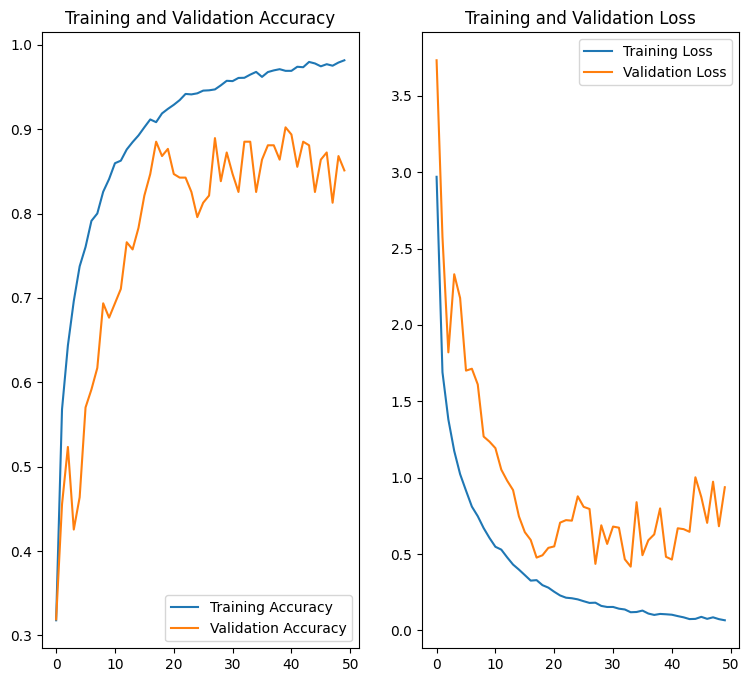

In [20]:
# 모델 평가
import matplotlib.pyplot as plt

acc = result.history['accuracy']            # train 과정에서의 accuracy           
val_acc = result.history['val_accuracy']    # validation 과정에서의 accuracy

loss = result.history['loss']               # train 과정에서의 loss
val_loss = result.history['val_loss']       # validation 과정에서의 loss

epochs_range = range(50)                    # x축: 에포크 수

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 결과 성공적

In [33]:
import numpy as np
image_path="C:\\Users\\user\\Desktop\\DLP_project\\test_face.jpg"  # 사용자가 원하는 사진의 경로를 입력(단, 얼굴 위주의 160*160사이즈의 사진이어야 함)

classes=train_generator.class_indices # 훈련 데이터셋의 클래스 인덱스를 가져옴.
class_names=list(classes.keys())   

img = tf.keras.preprocessing.image.load_img( #
    image_path, target_size=(rows, cols)
)

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array=img_array/255.

score = model.predict(img_array)

print("사진 속 인물은 {} 와 닮았습니다.".format(class_names[np.argmax(score)][0:].title()))

사진 속 인물은 Kimchaewon 와 닮았습니다.
